## Memory Bound Problems

In [1]:
import dask.dataframe as dd
from dask_kubernetes import KubeCluster
from dask.distributed import Client

In [2]:
cluster = KubeCluster(n_workers=100)
cluster

In [3]:
client = Client(cluster)

# Algos

In [4]:
import dask_ml.datasets

In [5]:
n_samples = 100_000_000
chunks = n_samples // 200

X, y = dask_ml.datasets.make_blobs(n_samples=n_samples, n_features=100,
                                   chunks=chunks)
display(X)

,Array,Chunk
Bytes,80.00 GB,400.00 MB
Shape,"(100000000, 100)","(500000, 100)"
Count,800 Tasks,200 Chunks
Type,float64,numpy.ndarray


In [6]:
X, y = client.persist([X, y])

In [7]:
import dask_ml.cluster

kmeans = dask_ml.cluster.KMeans(max_iter=5, init_max_iter=5)

In [8]:
%time kmeans.fit(X)

CPU times: user 38.2 s, sys: 3.14 s, total: 41.3 s
Wall time: 1min 3s


KMeans(algorithm='full', copy_x=True, init='k-means||', init_max_iter=5,
       max_iter=5, n_clusters=8, n_jobs=1, oversampling_factor=2,
       precompute_distances='auto', random_state=None, tol=0.0001)

In [9]:
kmeans.inertia_

993351053.1977963

In [10]:
client.restart()

distributed.utils - ERROR - 'tcp://10.21.1.25:37167'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/distributed/utils.py", line 662, in log_errors
    yield
  File "/opt/conda/lib/python3.7/site-packages/distributed/scheduler.py", line 1524, in add_worker
    await self.handle_worker(comm=comm, worker=address)
  File "/opt/conda/lib/python3.7/site-packages/distributed/scheduler.py", line 2437, in handle_worker
    worker_comm = self.stream_comms[worker]
KeyError: 'tcp://10.21.1.25:37167'
distributed.core - ERROR - 'tcp://10.21.1.25:37167'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/distributed/core.py", line 403, in handle_comm
    result = await result
  File "/opt/conda/lib/python3.7/site-packages/distributed/scheduler.py", line 1524, in add_worker
    await self.handle_worker(comm=comm, worker=address)
  File "/opt/conda/lib/python3.7/site-packages/distributed/scheduler.py", line 2437, in handle_worker
    work

Client Scheduler: tcp://10.20.0.189:40169 Dashboard: /user/dask/proxy/8787/status,Cluster Workers: 97 Cores: 97 Memory: 533.50 GB


## Hyperband

In [13]:
%matplotlib inline

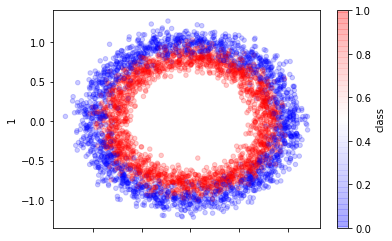

In [40]:
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state

import numpy as np
import pandas as pd

X, y = make_circles(n_samples=500_000, random_state=0, noise=0.09)

pd.DataFrame({0: X[:, 0], 1: X[:, 1], "class": y}).sample(4_000).plot.scatter(
    x=0, y=1, alpha=0.2, c="class", cmap="bwr"
)

In [41]:
rng = check_random_state(42)
random_feats = rng.uniform(-1, 1, size=(X.shape[0], 4))
X = np.hstack((X, random_feats))
X.shape


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=5_000, random_state=42)
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [42]:
import dask
import dask.array as da
import numpy as np

In [43]:
@dask.delayed(nout=2)
def clone(X, y, seed=None, noise=0.9):
    random_state = check_random_state(seed)
    X = X + random_state.normal(scale=noise, size=X.shape)
    return X, y

In [44]:
Xs, ys = zip(*[clone(X, y, seed=i) for i in range(1000)])
Xs = [da.from_delayed(x, dtype=X.dtype, shape=X.shape) for x in Xs]
ys = [da.from_delayed(x, dtype=y.dtype, shape=y.shape) for x in ys]

X_big = da.concatenate(Xs)
y_big = da.concatenate(ys)

In [45]:
X_big

,Array,Chunk
Bytes,24.00 GB,24.00 MB
Shape,"(500000000, 6)","(500000, 6)"
Count,4000 Tasks,1000 Chunks
Type,float64,numpy.ndarray


In [31]:
y_big

,Array,Chunk
Bytes,4.80 GB,4.80 MB
Shape,"(600000000,)","(600000,)"
Count,4000 Tasks,1000 Chunks
Type,int64,numpy.ndarray


In [26]:
X, y = client.persist([X_big, y_big])

In [13]:
from distributed import wait

wait(X);

## Specify the Model

In [29]:
max_iter = n_params = 15

In [31]:
import numpy as np
from sklearn.neural_network import MLPClassifier

model = MLPClassifier()
params = {
    "hidden_layer_sizes": [
        (24, ),
        (12, 12),
        (6, 6, 6, 6),
        (4, 4, 4, 4, 4, 4),
        (12, 6, 3, 3),
    ],
    "activation": ["relu", "logistic", "tanh"],
    "alpha": np.logspace(-6, -3, num=1000),  # cnts
    "batch_size": [16, 32, 64, 128, 256, 512],
}

In [32]:
import dask_ml.model_selection

In [33]:
search = dask_ml.model_selection.HyperbandSearchCV(
    model,
    params,
    max_iter=15,
    patience=True,
)


In [34]:
search.fit(X, y, classes=[0, 1])

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://10.20.0.189:38972 remote=tcp://10.20.0.189:35643>
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


HyperbandSearchCV(aggressiveness=3,
                  estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                          batch_size='auto', beta_1=0.9,
                                          beta_2=0.999, early_stopping=False,
                                          epsilon=1e-08,
                                          hidden_layer_sizes=(100,),
                                          learning_rate='constant',
                                          learning_rate_init=0.001,
                                          max_iter=200, momentum=0.9,
                                          n_iter_no_change=10,
                                          nesterovs_momentum=True, power_t=0.5,
                                          random_state=None, shuffle...
       9.26759330e-04, 9.33189772e-04, 9.39664831e-04, 9.46184819e-04,
       9.52750047e-04, 9.59360829e-04, 9.66017480e-04, 9.72720319e-04,
       9.79469667e-04, 9.86265846e-04, 9.93109181

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [35]:
search.best_params_

{'hidden_layer_sizes': (12, 12),
 'batch_size': 128,
 'alpha': 0.000707701066118189,
 'activation': 'tanh'}

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


In [29]:
import pandas as pd

pd.DataFrame(search.cv_results_).sort_values("rank_test_score", ascending=False)

,test_score,std_score_time,params,model_id,bracket,param_alpha,param_hidden_layer_sizes,std_partial_fit_time,partial_fit_calls,mean_score_time,rank_test_score,param_activation,mean_partial_fit_time,param_batch_size
4,0.499560,0.000000,"{'hidden_layer_sizes': (12, 6, 3, 3), 'batch_s...",bracket=2-4,2,0.000039,"(12, 6, 3, 3)",0.000000,1,1.060026,9,relu,1.411639,256
0,0.499800,0.000000,"{'hidden_layer_sizes': (12, 12), 'batch_size':...",bracket=2-0,2,0.000753,"(12, 12)",0.000000,1,0.966873,8,logistic,1.397073,128
5,0.500180,0.000000,"{'hidden_layer_sizes': (24,), 'batch_size': 51...",bracket=2-5,2,0.000010,"(24,)",0.000000,1,0.521719,7,logistic,32.640391,512
7,0.500440,0.000000,"{'hidden_layer_sizes': (4, 4, 4, 4, 4, 4), 'ba...",bracket=2-7,2,0.000011,"(4, 4, 4, 4, 4, 4)",0.000000,1,1.557961,5,logistic,4.994784,64
2,0.500440,0.000000,"{'hidden_layer_sizes': (4, 4, 4, 4, 4, 4), 'ba...",bracket=2-2,2,0.000002,"(4, 4, 4, 4, 4, 4)",0.000000,1,1.685948,5,logistic,4.948418,64
12,0.501267,0.048888,"{'hidden_layer_sizes': (6, 6, 6, 6), 'batch_si...",bracket=1-3,1,0.000154,"(6, 6, 6, 6)",0.250799,5,1.191692,4,logistic,1.307150,256
11,0.501267,0.137963,"{'hidden_layer_sizes': (12, 6, 3, 3), 'batch_s...",bracket=1-2,1,0.000322,"(12, 6, 3, 3)",0.898872,5,1.262447,4,logistic,6.579231,32
8,0.500927,0.000000,"{'hidden_layer_sizes': (12, 12), 'batch_size':...",bracket=2-8,2,0.000011,"(12, 12)",0.000000,1,0.986745,4,logistic,1.385240,128
1,0.526887,0.108826,"{'hidden_layer_sizes': (6, 6, 6, 6), 'batch_si...",bracket=2-1,2,0.000004,"(6, 6, 6, 6)",0.637139,3,1.294002,3,tanh,6.670577,32
13,0.523043,0.001180,"{'hidden_layer_sizes': (4, 4, 4, 4, 4, 4), 'ba...",bracket=1-4,1,0.000003,"(4, 4, 4, 4, 4, 4)",0.562158,5,1.655784,3,tanh,4.880780,64


MLPClassifier(activation='tanh', alpha=0.000707701066118189, batch_size=128,
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(12, 12), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [35]:
pd.DataFrame(search.history_)

,model_id,params,partial_fit_calls,partial_fit_time,score,score_time,elapsed_wall_time,bracket
0,bracket=0-0,"{'hidden_layer_sizes': (12, 6, 3, 3), 'batch_s...",1,4.951982,0.498123,0.811104,11.422107,0
1,bracket=0-1,"{'hidden_layer_sizes': (24,), 'batch_size': 25...",1,1.106827,0.515110,0.964333,11.422109,0
2,bracket=0-2,"{'hidden_layer_sizes': (4, 4, 4, 4, 4, 4), 'ba...",1,5.556502,0.498123,1.599597,11.422110,0
3,bracket=1-0,"{'hidden_layer_sizes': (24,), 'batch_size': 16...",1,8.431917,0.529987,0.822209,17.986526,1
4,bracket=1-1,"{'hidden_layer_sizes': (24,), 'batch_size': 25...",1,0.985011,0.507620,1.007002,17.986528,1
5,bracket=1-2,"{'hidden_layer_sizes': (12, 6, 3, 3), 'batch_s...",1,7.478103,0.498733,1.400410,17.986529,1
6,bracket=1-3,"{'hidden_layer_sizes': (6, 6, 6, 6), 'batch_si...",1,1.557949,0.501267,1.240580,17.986529,1
7,bracket=1-4,"{'hidden_layer_sizes': (4, 4, 4, 4, 4, 4), 'ba...",1,5.442938,0.507137,1.654604,17.986530,1
8,bracket=0-1,"{'hidden_layer_sizes': (24,), 'batch_size': 25...",6,0.863388,0.529827,0.731273,35.004537,0
9,bracket=0-0,"{'hidden_layer_sizes': (12, 6, 3, 3), 'batch_s...",6,3.942332,0.498123,1.007946,35.004540,0


In [36]:
cluster.scale(0)

Task exception was never retrieved
future: <Task finished coro=<Pod.close() done, defined at /opt/conda/lib/python3.7/site-packages/dask_kubernetes/core.py:76> exception=ApiException()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/dask_kubernetes/core.py", line 79, in close
    self._pod.metadata.name, self.namespace
  File "/opt/conda/lib/python3.7/site-packages/kubernetes_asyncio/client/api_client.py", line 166, in __call_api
    _request_timeout=_request_timeout)
  File "/opt/conda/lib/python3.7/site-packages/kubernetes_asyncio/client/rest.py", line 219, in DELETE
    body=body))
  File "/opt/conda/lib/python3.7/site-packages/kubernetes_asyncio/client/rest.py", line 181, in request
    raise ApiException(http_resp=r)
kubernetes_asyncio.client.rest.ApiException: (404)
Reason: Not Found
HTTP response headers: <CIMultiDictProxy('Audit-Id': '204b4358-83e1-40cb-98b0-8e05ab0c02d5', 'Content-Type': 'application/json', 'Date': 'Tue, 29 Oct 2019 19:18:53 